In [2]:
import cv2
import os
import json
import sqlite3
from matplotlib import pyplot as plt

# Create folders if not already created
os.makedirs("uploaded", exist_ok=True)
os.makedirs("answer_keys", exist_ok=True)

In [138]:
def detect_bubbles(image_path, show=False):
    img = cv2.imread(image_path, 0)
    if img is None:
        raise ValueError("Image not found or unreadable.")

    blurred = cv2.GaussianBlur(img, (7, 7), 0)
    _, thresh = cv2.threshold(blurred, 130, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    bubbles = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if 300 < area < 700:
            x, y, w, h = cv2.boundingRect(cnt)
            bubbles.append((x, y, w, h))
    bubbles = sorted(bubbles, key=lambda b: (b[0], b[1]))  # sort top to bottom, left to right
    print(f"✅ Detected {len(bubbles)} bubbles")

    if show:
        img_color = cv2.imread(image_path)
        for (x, y, w, h) in bubbles:
            cv2.rectangle(img_color, (x, y), (x+w, y+h), (0, 255, 0), 2)
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
        plt.title("Detected Bubbles")
        plt.axis('off')
        plt.show()

    return bubbles

In [139]:
import os
print(os.listdir("uploaded"))

['Img1.jpeg', 'Img10.jpeg', 'Img11.jpeg', 'Img12.jpeg', 'Img13.jpeg', 'Img14.jpeg', 'Img15.jpeg', 'Img16.jpeg', 'Img17.jpeg', 'Img18.jpeg', 'Img19.jpeg', 'Img2.jpeg', 'Img20.jpeg', 'Img21.jpeg', 'Img22.jpeg', 'Img23.jpeg', 'Img3.jpeg', 'Img4.jpeg', 'Img5.jpeg', 'Img6.jpeg', 'Img7.jpeg', 'Img8.jpeg', 'Img9.jpeg']


✅ Detected 127 bubbles


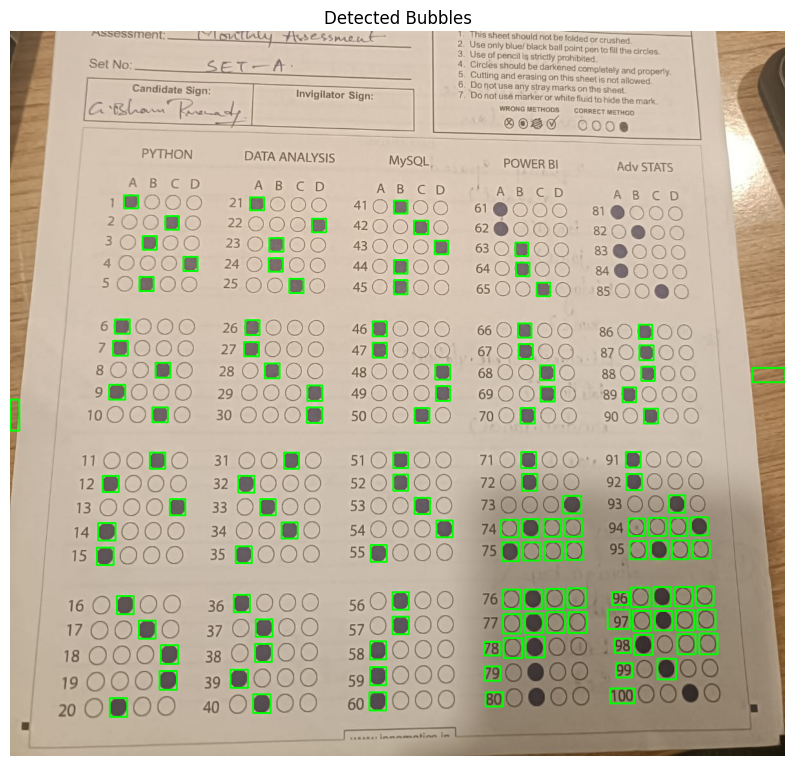

In [140]:
bubbles = detect_bubbles("uploaded/img1.jpeg", show=True)

In [141]:
def is_marked(img, bubble):
    x, y, w, h = bubble
    roi = img[y:y+h, x:x+w]
    filled_pixels = cv2.countNonZero(roi)
    total_pixels = roi.size
    fill_ratio = filled_pixels / total_pixels
    return fill_ratio > 0.5

In [142]:
img_gray = cv2.imread("uploaded/img1.jpeg", 0)
marked_bubbles = []

for i, bubble in enumerate(bubbles):
    if is_marked(img_gray, bubble):
        marked_bubbles.append(i+1)

print(f"✅ Marked bubbles: {marked_bubbles}")

✅ Marked bubbles: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]


In [143]:
def map_bubbles_to_questions(bubbles):
    question_map = {}
    group_size = 5  # 5 options per question

    # Group bubbles into vertical sets
    for i in range(0, len(bubbles), group_size):
        q_no = (i // group_size) + 1
        options = ['A', 'B', 'C', 'D', 'E']
        vertical_group = sorted(bubbles[i:i+group_size], key=lambda b: b[1])  # sort top to bottom
        question_map[q_no] = dict(zip(options, vertical_group))
    return question_map

In [144]:
def get_marked_answers(img, question_map):
    marked = {}
    for q_no, options in question_map.items():
        for opt, bubble in options.items():
            if is_marked(img, bubble):
                marked[q_no] = opt
                break  # only one option per question
    return marked

In [145]:
def load_answer_key(set_name):
    path = f"answer_keys/{set_name}.json"
    with open(path, "r") as f:
        return json.load(f)

answer_key = load_answer_key("set_a")
print("✅ Loaded answer key")

✅ Loaded answer key


In [146]:
def evaluate_answers(marked_answers, answer_key):
    score = 0
    subject_scores = {}

    for subject, answers in answer_key.items():
        correct = 0
        for q_no, correct_opt in answers.items():
            try:
                q_no_int = int(q_no)
                if q_no_int in marked_answers:
                    if marked_answers[q_no_int] == correct_opt:
                        correct += 1
            except Exception as e:
                print(f"⚠ Error comparing Q{q_no}: {e}")
        subject_scores[subject] = correct
        score += correct

    print("✅ Subject-wise Scores:", subject_scores)
    return score, subject_scores

In [147]:
img = cv2.imread("uploaded/img1.jpeg", 0)
bubbles = detect_bubbles("uploaded/img1.jpeg")
question_map = map_bubbles_to_questions(bubbles)
marked_answers = get_marked_answers(img, question_map)
print("✔ Marked Answers:", marked_answers)

answer_key = load_answer_key("set_a")  # or "set_b"
score, subject_scores = evaluate_answers(marked_answers, answer_key)
print(f"🏆 Total Score: {score}")

✅ Detected 127 bubbles
✔ Marked Answers: {1: 'A', 2: 'A', 3: 'A', 4: 'A', 5: 'A', 6: 'A', 7: 'A', 8: 'A', 9: 'A', 10: 'A', 11: 'A', 12: 'A', 13: 'A', 14: 'A', 15: 'A', 16: 'A', 17: 'A', 18: 'A', 19: 'A', 20: 'A', 21: 'A', 22: 'A', 23: 'A', 24: 'A', 25: 'A', 26: 'A'}
✅ Subject-wise Scores: {'PYTHON': 12, 'EDA': 2, 'SQL': 0, 'POWER_BI': 0, 'STATISTICS': 0}
🏆 Total Score: 14


In [149]:
def save_result(student_id, score):
    conn = sqlite3.connect("results.db")
    cursor = conn.cursor()
    cursor.execute('''CREATE TABLE IF NOT EXISTS results (
                        student_id TEXT,
                        score INTEGER)''')
    cursor.execute("INSERT INTO results VALUES (?, ?)", (student_id, score))
    conn.commit()
    conn.close()

    
save_result("Gokulam Randy", score)
print("✅ Result saved to database")

✅ Result saved to database
